# GSSR
Gene Splice Site Recognition by WAM, Bayesian Network and SVM approaches

## Abstract

As molecular biology has an insight into gene regulation and RNA splicing, recognition of RNA splice site became a key problem. In recent 2 decades, several methods have been proposed to solve the problem. But there are some limitations, Weighted Array method can just handle specific range of dependence between bases on DNA sequence, and Bayesian Network still have much space to optimize, SVM is very accurate but much like a blackbox. In this article, I proposed a new Bayesian Network method to determine dependence graph for the Splicing signal of sequence. Which differs to [ref], and shows a great potential to show the details in model. Besides, I also performed a fair comparison for three methods.

## Introduction

As molecular biology has an insight into gene regulation and RNA splicing, recognition of RNA splice site became a key problem. In recent 2 decades, several methods have been proposed to solve the problem. But there are some limitations, Weighted Array method can just handle specific range of dependence between bases on DNA sequence, and Bayesian Network still have much space to optimize, SVM is very accurate but much like a blackbox.

### Splice Site
https://en.wikipedia.org/wiki/RNA_splicing

Splice site, in molecular biology, is a position on RNA where RNA splicing occurs. RNA splicing is a form of RNA processing in which a newly made precursor messenger RNA (pre-mRNA) transcript is transformed into a mature messenger RNA (mRNA). After splicing, introns (Non-coding regions) are removed and exons (Coding Regions) are joined together. Each exon begins with a donor and ends with an acceptor.

### Models

As Biology advances, computational methods are now the only realistic way to answer many questions in modern biology[ref]. For the problem of splice site recognition, there are several models have been peoposed.

**Weighted Array Model** is a statistics-based approach, it calculate the frequency of each adjacent bases in specific positions to fill into a weight array matrix, and use weight matrix to score unknown site. The limitation of this approach, in my opinion, is its poor ability to automatically calculate new feature, like GC content. There might be much more complex features that contribute to splice signal transduction. 

**Bayeisan Network** is a Bayesian method, it is ... 

**Support Vector Machine** is a [] method, ... and others

https://academic.oup.com/bioinformatics/article-abstract/9/5/499/349215?redirectedFrom=PDF

https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-9-477

https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-8-S10-S7

### Packages

introductions of Scikit-learn[ref] and Pgmpy[ref]

## Material and Method

### Environment

In [2]:
import warnings
import import_ipynb
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.image as pli
from Models import WAM, BN, SVM
from Evaluator import Evaluator
from matplotlib import pyplot as plt
from Utils import load_data, Summary
from IPython.display import display, Markdown
from pgmpy.estimators import MmhcEstimator, ConstraintBasedEstimator

plt.ion()
plt.style.use(['science','ieee','no-latex'])
warnings.filterwarnings("ignore")

importing Jupyter notebook from Models.ipynb
importing Jupyter notebook from Utils.ipynb
importing Jupyter notebook from Evaluator.ipynb


### Datasets

In [ ]:
training_set, testing_set = load_data()
training_set1 = training_set[0:5000]
testing_set1 = testing_set[0:5000]
training_set2 = training_set[1500:6500].reset_index(drop=True)
testing_set2 = testing_set[1500:6500].reset_index(drop=True)

To comprehensively compare their performances, two data sets were used as data are usually unbalanced in Biology. Models may performs different in that way. The first data set, which is balanced, was used to *training* and testing models' performance in a general way. And the second dataset is an unbalanced data set, was used to *training* and thus testing their performance like real conditions. Because unbalanced data is a common in Biology and many other feilds.

The basic information of the two data sets are as follows.

In [5]:
Summary(training_set1, testing_set1, training_set2, testing_set2)

,nDonor (Training),nPseudo (Training),nDonor (Testing),nPseudo (Testing),nSample,nDonor : nPSeudo,Type
Dataset 1,139,361,139,361,1000,139 : 361,Unbalanced
Dataset 2,239,261,239,261,1000,239 : 261,Balanced


### Feature Extraction and Encoding

To build reliable models and test their performances, high-quanlity data must be extracted. Splice site dataset , which contains [] real donor site and [] acceptor site and [] pseudosite, was extracted from original sequence data. And only 10 bases before and after specific site are selected as our feature. Additionally, only [] donor site and [] pseudosite are used in the experiments because of low computing power of computer, comparison on acceptor sites still remains undone.

When encoding sequence features, a one-hot encoder were used. And for consideration of simplisity of problem, the ambiguous bases in sequences were disgarded. A simple example is that when deeling with sequence A, which can be represented as $acgtay^* aaccggttr^* y^* $, the ambiguous bases $y^*$ and $r^*$ are simply disgarded. So the sequence A becomes $acgtaaaccggtt$. And next, a One-hot encoder are used to encode sequence A to a numeric feature vector, which can be represented as $[1,0,0,0...0,0,0,1]$. In all of my experiments, I used 10 bases before and after the site to be tested, including its own sequence with a total length of 21.

### Model implements and Test score

The 3 models are mainly implemented using Python. Besides, the Bayesian network model and Support vector machine were implemented based on Pgmpy and Scikit-learn pacakge. The 3 models are designed to be *[put into practical use]* as much as possible. They contain several very easy-to-use program interfaces: `fit`, `predict_probas`, `predict_scores` and `predict_classes`. For all 3 models, the `fit` method are used for training, and the other 3 `predict` methods are used for prediction. The `predict_probas` are used for predicting the probabilities each sample belonging to each class, the `predict_scores` are used for calculating the $S(X)$, and the `predict_classes` are used for predicting the class to which each sample belongs, this is done by comparing the $S(X)$ and given threshold $T$ (Equation []). Most importantly, the $S(X)$ are calculated by:
$$S_m(X) = ln(\frac{P_m^+ (X)}{P_m^- {X}}), m\in[wam, bn, svm] \tag{1}$$

#### Stratagies for WAM to perform recognition

When recoginizing Gene Splice Site, the 3 steps were mainly used to determine the potential of each sample being a splice site. Firstly, Laplace Pseudocounts are used to [...]. Secondly, the weights of positive and negative submodels, which are the frequencies of adjacent base pairs in WAM, are calculated using the following formula.
$$f(x) = \frac{C_{x,p}+C_p}{N},x \in [aa,ac,ag,...tt] \tag{2} $$ where $N$ is the total number of samples. $C_{x,p}$ is the total number of specific adjacent base pairs occuring at position $p-l+1...p$ in all samples. $C_p$ is the pseudocount, and $l$ is the length of array considered, which refers to the range of dependence between adjacent base pairs considered in experiments. And finally, the potential of new samples being a donor site can be easily calculated by
$$S_{wam}(X) = ln(\frac{P^+(X)}{P^-(X)}) = \sum_{x=2}^{L}{ln(\frac{f^+(x)}{f^-(x)})} \tag{}$$
where $L$ is the length of input sequence.
Most importantly, $l$ and $C_p$ are set to $2$ and $0.5$ respectively. 

#### Stratagies for BN to learn structures and parameters from data

To perform accurate structure and parameter learning for Bayesian Network, Two algorithms were used: The Max-Min Hill-Climbing (MMHC) algorithm [1] for structure learning and Bayesian Estimator for parameters learning. 

##### Structure learning

MMHC algorithm is a hybrid learning algorithm, proposed by *[AUTHOR]*. The algorithm combines ideas from Constraint-based learning algorithms and Score-based learning algorithms etc.[1] The algorithm performs accurate structure by two steps: construct the skeleton for Bayesian network using Max-Min Parent-Child [2] algorithm and orients the edges by a Bayesian-scoring greedy Hill-Climbing search [3].

##### Parameter learning

[details of Parameter learning]

#### Strategies for BN to detect splice signal [review sourcecode ]

Because of bayesian inference, bayesian network can handle the causual relationship between nodes. So I have made a simpler but useful bayesian network, In which both two kinds of data are remained: the feature nodes $N_{f}, f\in [-10,-9,...10]$ and label node $N_L$. In the bayesian network, each feature node has $state_f \in [a,c,g,t]$ and label node have $state_L\in [0,1]$. And both donor sites and pseudo sites are fitted in one bayesian network, because bayesian network has the ability to detect causual relationship between state across all nodes. eg. $state_0=g$ and $state_L=1$ . 
Finally, when predicting new sites, the bayeisan network will treat new sites as sample with missing value (label as missing value). It just [] get value.

#### Correction

Since Bayesian network cannot perfectly inference the causual relationship between $N_f$ and $N_L$, I made a simple correction for its structure. After construting a DAG structure, the edges from $N_L$ to any one of $N_f$ are *reversed*. For example, the edge $N_L \rightarrow N_{-1}$ are reversed into $N_L \leftarrow N_{-1}$.

#### Settings for SVM to classify splice sites

In the experiment, Gaussian Kernel function (see below) were used to map vectors to higher-dimensional feature space. The 惩罚系数 $C$ are used to .... And the key parameter $\gamma$ for Gaussian Kernel are set to [real gamma].
$$\tag{4}K(x_i, x_j) = exp(-\gamma||x_i - x_j||^2), \gamma > 0$$

more detail

In [7]:
class Model:
    
    def __init__(self):
        self.wam = WAM()
        self.bn = BN(#struc_estr=ConstraintBasedEstimator, 
                     struc_estr=MmhcEstimator#, max_ci_vars=5
                    )
        self.svm = SVM(kernel='rbf', gamma='scale', random_state=1, probability=True, verbose=True)
        
model_1 = Model()
model_2 = Model()

### Cross-validation

To test the accuracy of three models, a simple cross-validation was performed. I choosed [] donor sites and [] pseudo sites as testing set, and each model was tested on this testing set.

### Evaluation

To visualize and compare classification results of 3 models, ROC Curves and Sn-Sp Curves are plotted using matplotlib package. To realize this, a sample-based evaluation method is introduced:

$$ 
\begin{align} 
TP_t = \sum_{i=0}^N I(S_i\geq t \land L_i = 1) \tag{} \\
FP_t = \sum_{i=0}^N I(S_i\geq t \land L_i = 0) \tag{} \\
TN_t = \sum_{i=0}^N I(S_i< t \land L_i = 0) \tag{} \\
FN_t = \sum_{i=0}^N I(S_i< t \land L_i = 1) \tag{} \\
\end{align}
$$
where $TP_t$, $FP_t$, $TP_t$, $TN_t$ are statistics for models' prediction result in specific threshold $t$, detailed expanalation [...]. $I(True) = 0$ and $I(False) = 1$, $L_i$ is label for $ith$ sample. $S_i$ is the score calculated based on probability for $ith$ sample. $t\in [-25, -24.5, -24, ...24.5, 25]$ is the threshold used in evaluation. 

And following statistics were used in our evaluation.
$$
\begin{align} 
TPR_t & = \frac{TP_t}{TP_t+FN_t} \tag{} \\
FPR_t & = \frac{FP_t}{FP_t+TN_t} \tag{} \\
Sn_t & = \frac{TP_t}{TP_t+FN_t} \tag{} \\
Sp_t & = \frac{TN_t}{TN_t+FP_t} \tag{} \\
Pr_t & = \frac{TP_t}{TP_t+FP_t} \tag{} \\
Rc_t & = \frac{TP_t}{TP_t+FN_t} \tag{} \\
\end{align}
$$



Finally, $auROC$ (area under ROC curve) and $auPRC$ (area under Precision-Recall curve) were calculated using Composite Trapezoidal rule [ref]:

$$
\begin{align}
auROC &= \sum_{i=1}^{N-1} \frac{(FPR_{i+1} - FPR_i)(TPR_i+TPR_{i+1})}{2} \tag{} \\
auPRC &= \sum_{i=1}^{N-1} \frac{(Rc_{i+1} - Rc_i)(Pr_i+Pr_{i+1})}{2} \tag{} \\
\end{align}
$$

https://github.com/scikit-learn/scikit-learn/blob/fd237278e/sklearn/metrics/_ranking.py#L42

https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.trapz.html

https://github.com/numpy/numpy/blob/v1.16.2/numpy/lib/function_base.py#L3982-L4070

## Result and Discussion

#### Model Training

Three models were trained here.

In [8]:
#display(training_set)
model_1.wam.fit(training_set1['Seq. features'], training_set1['IsDonor'])
model_2.wam.fit(training_set2['Seq. features'], training_set2['IsDonor'])
pd.set_option('display.max_columns', None)
p_rename = lambda x: 'P.{}'.format(x)
n_rename = lambda x: 'N.{}'.format(x)
scores_wam_1 = model_1.wam.predict_scores(testing_set1['Seq. features'].apply(str.upper))
scores_wam_2 = model_2.wam.predict_scores(testing_set2['Seq. features'].apply(str.upper))

processing...: 100%|██████████| 16/16 [00:00<00:00, 283.25it/s]

Fitting model with positive data...
Fitting model with negative data...



processing...: 100%|██████████| 16/16 [00:00<00:00, 253.24it/s]


Fitting model with positive data...
Fitting model with negative data...


In [9]:
model_2.bn.fit(seqs=training_set2['Seq. features'], 
               label=training_set2['IsDonor'].astype(int), sign_level=0.01)
model_1.bn.fit(seqs=training_set1['Seq. features'], 
               label=training_set1['IsDonor'].astype(int), sign_level=0.01)
scores_bn_1 = model_1.bn.predict_scores(testing_set1['Seq. features'])
scores_bn_2 = model_2.bn.predict_scores(testing_set2['Seq. features'])

Performing structure learning, using estimator: `<class 'pgmpy.estimators.MmhcEstimator.MmhcEstimator'>`
Done !
Performing parameter learning, using estimator: `<class 'pgmpy.estimators.BayesianEstimator.BayesianEstimator'>`
Performing structure learning, using estimator: `<class 'pgmpy.estimators.MmhcEstimator.MmhcEstimator'>`
Done !
Performing parameter learning, using estimator: `<class 'pgmpy.estimators.BayesianEstimator.BayesianEstimator'>`


In [10]:
to_format_arr = lambda data: np.array([np.array(list(i)) for i in data])
model_1.svm.fit(to_format_arr(training_set1['Num. features']), training_set1['IsDonor'])
model_2.svm.fit(to_format_arr(training_set2['Num. features']), training_set2['IsDonor'])
scores_svm_1 = model_1.svm.predict_scores(to_format_arr(testing_set1['Num. features']))
scores_svm_2 = model_2.svm.predict_scores(to_format_arr(testing_set2['Num. features']))

[LibSVM][LibSVM]

In [16]:
import pickle

d = {'m1': model_1, 'm2': model_2}
with open('../models/models.pkl', 'wb') as f:
    pickle.dump(d, f)

### Splice signal detection by WAM (Weights for WAM)

As Weighted array model calculate adjacent bases frequencies at each position, it can only detect common adjacent bases near the splice sites. In both two experiments, WAM has detected the information well (see figure 1.). The result shows that GT, GG, GC are common bases near splice site. **The main reason of this would be.... It could be used to ... Genescan like method...**

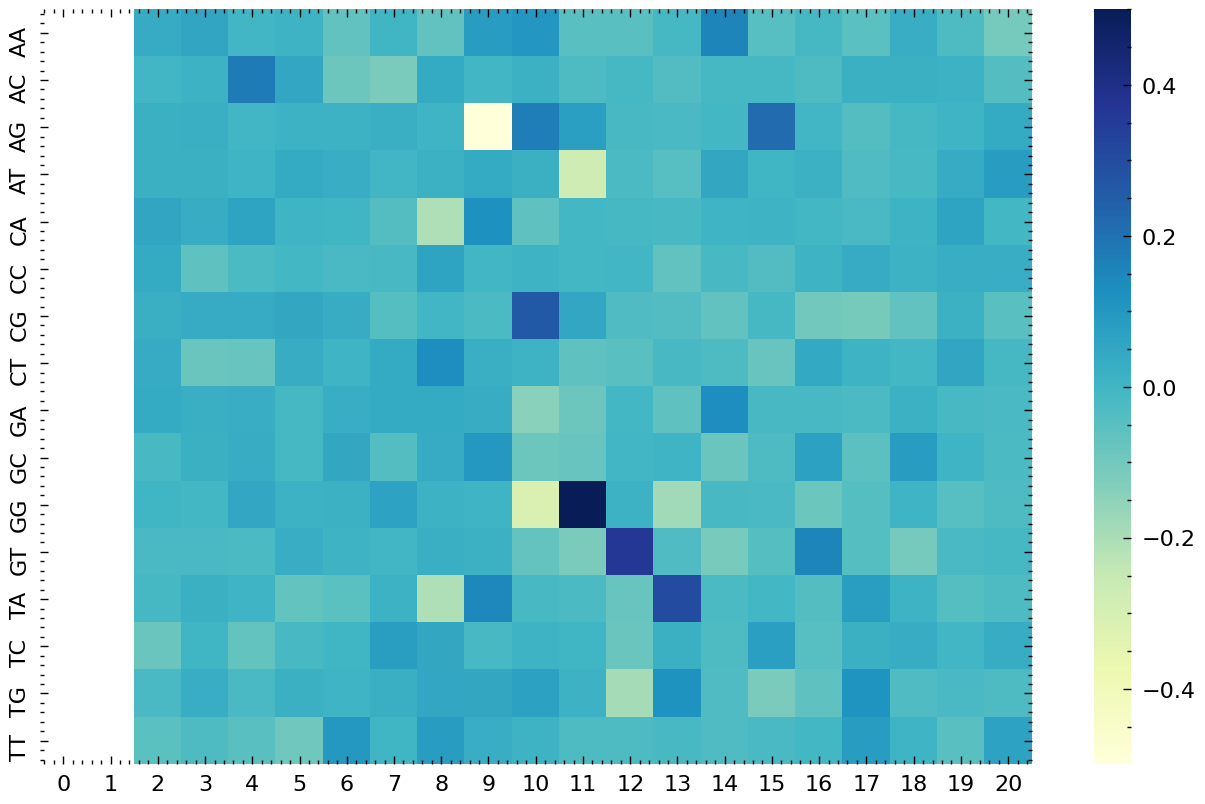

In [25]:
weights_diff = model_1.wam.positive_weights - model_1.wam.negative_weights
plt.figure(figsize=(8,5), dpi=200)
ax = sns.heatmap(weights_diff.T, vmin=-0.5, vmax=0.5
                 ,cmap="YlGnBu"
                )

### Graph for BN

Bayesian network uses $\chi^2 -test$ and conditional independent test, to build dependency gragh for each position near splice site and also Donor potential. In both two experiments, BN has detected the condetional dependences between positions and Donor potential [Figure 2], and conditional probability distribution were learned and this can calculate the potential of unknown sites being a Donor site.

fixhere G2

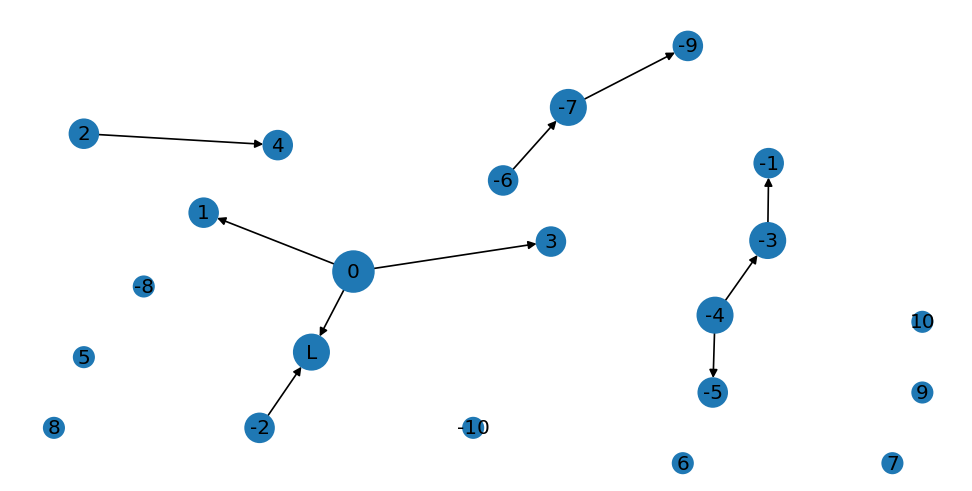

In [12]:
plt.figure(figsize=(8,4), dpi=120)
G = model_2.bn.networks
bicolors = ['deepskyblue','salmon']
nodesize = np.array([float(G.degree(v) + 1) for v in G])
nodecolor = np.array([bicolors[int('L' == i)] for i in G])
nx.draw(G, with_labels=True, textsize=10000, #node_color=nodecolor,
        pos=nx.nx_agraph.graphviz_layout (G, prog='neato'), 
        node_size=nodesize*150)

# a cpd plot

边缘化两个变量，另外两个变量flatten，再边缘化另外两个变量，值是阳性-阴性的概率，作出热图

### Performance
- running time measurement

# more plot

In [13]:
# 样本数目一直再重新运行和评估，一会改
import importlib
import Evaluator
importlib.reload(Evaluator)
from Evaluator import Evaluator

importing Jupyter notebook from Evaluator.ipynb


In [18]:
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import ConnectionPatch

trange = np.arange(-40, 40, 0.5)
ll = 0.9
ur = 1.005

evaltr_1 = Evaluator(labels=testing_set1['IsDonor'], 
                  wam_scores=scores_wam_1, 
                  bn_scores=scores_bn_1, 
                  svm_scores=scores_svm_1)
#df = evaltr.Cal_Rc_Pr_F1S(evaltr.Confusion_table(np.arange(-30, 30, 1))['wam_scores']).copy()

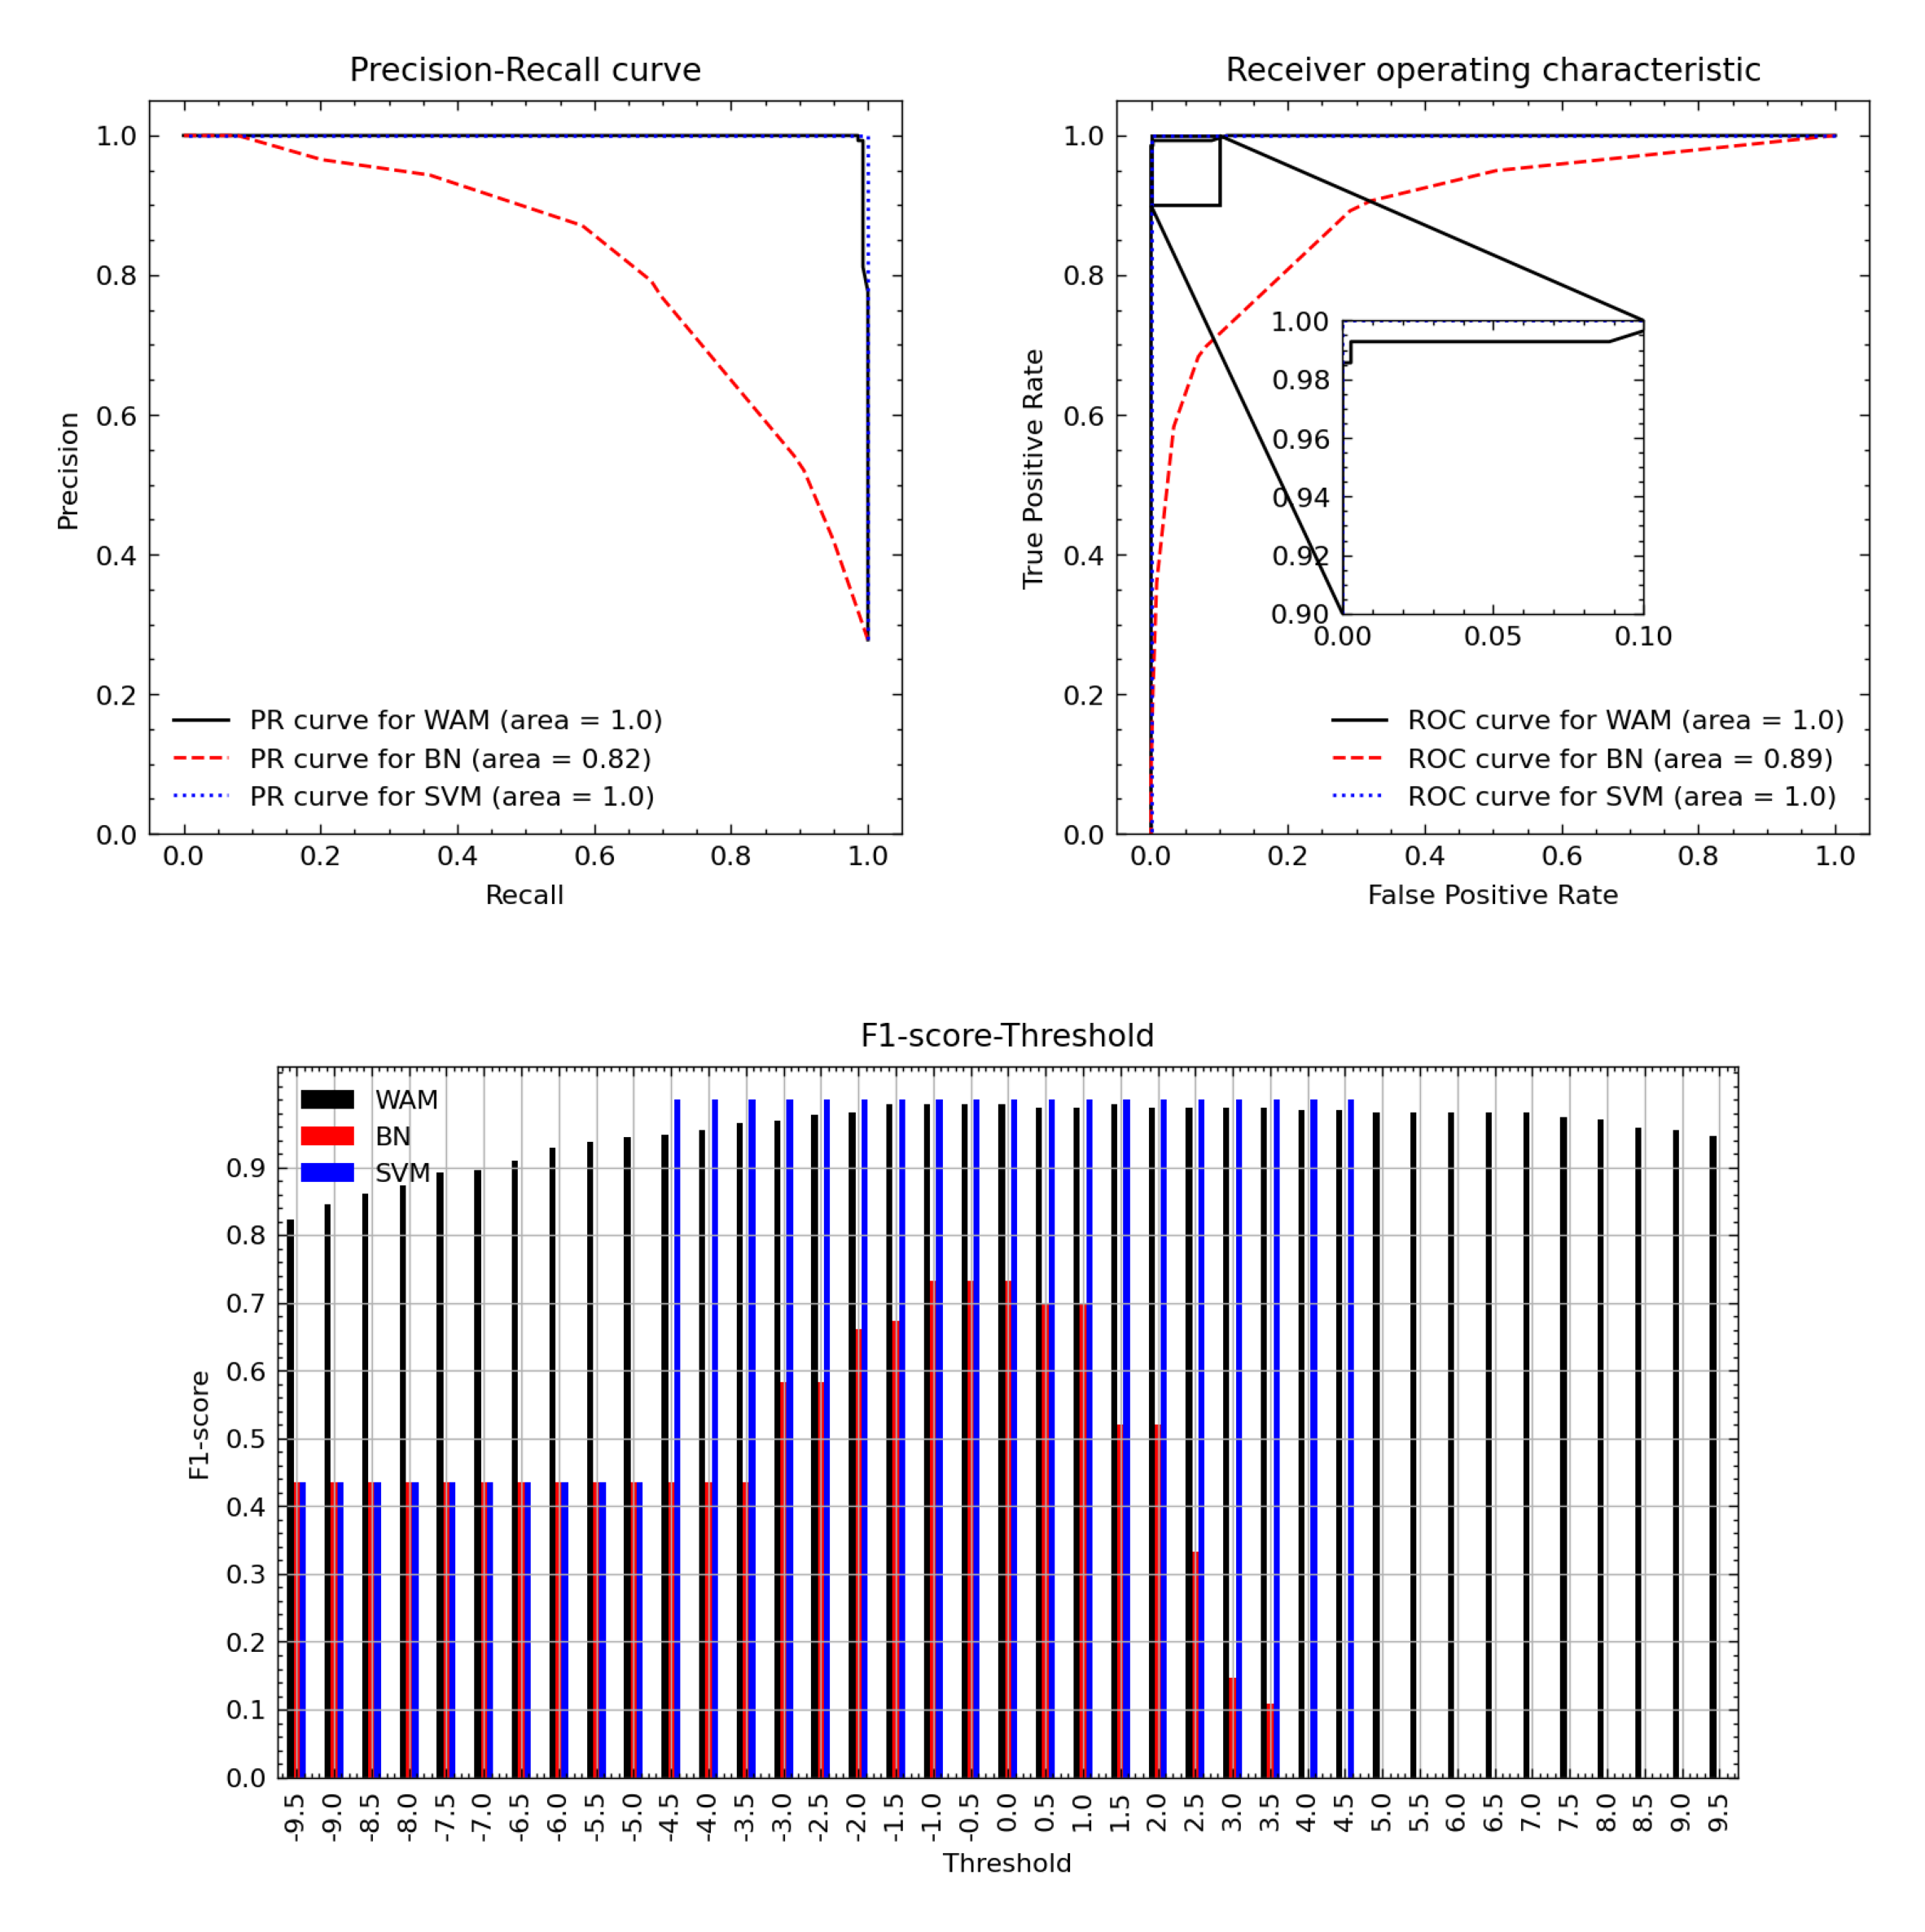

In [24]:
fig, ax = plt.subplots(1,1, figsize=(8,4), dpi=200)
evaltr_1.F1_t_Curves(fig, ax, T_range=np.arange(-10,10,0.5), xlim=[-10,10])
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
evaltr_1.ROC_Curves(fig, ax, T_range=trange, xlim=[-0.05, 1.05])
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
evaltr_1.PR_Curves(fig, ax, T_range=trange, xlim=[-0.05, 1.05])

figs = [pli.imread(i) for i in ['../Figures/F1_t.png', '../Figures/ROC.png', 
                                '../Figures/PRC.png']]

def no_box(ax):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    for key, spine in ax.spines.items():
        spine.set_visible(False)

plt.figure(figsize=(12,12), dpi=200)
plt.subplots_adjust(left=0.0,bottom=0.0,top=1,right=1)
ax1 = plt.subplot(2,2,1)
no_box(ax1); plt.imshow(figs[2])
ax2 = plt.subplot(2,2,2)
no_box(ax2); plt.imshow(figs[1])
ax3 = plt.subplot(2,1,2)
no_box(ax3); plt.imshow(figs[0])

plt.tight_layout() 

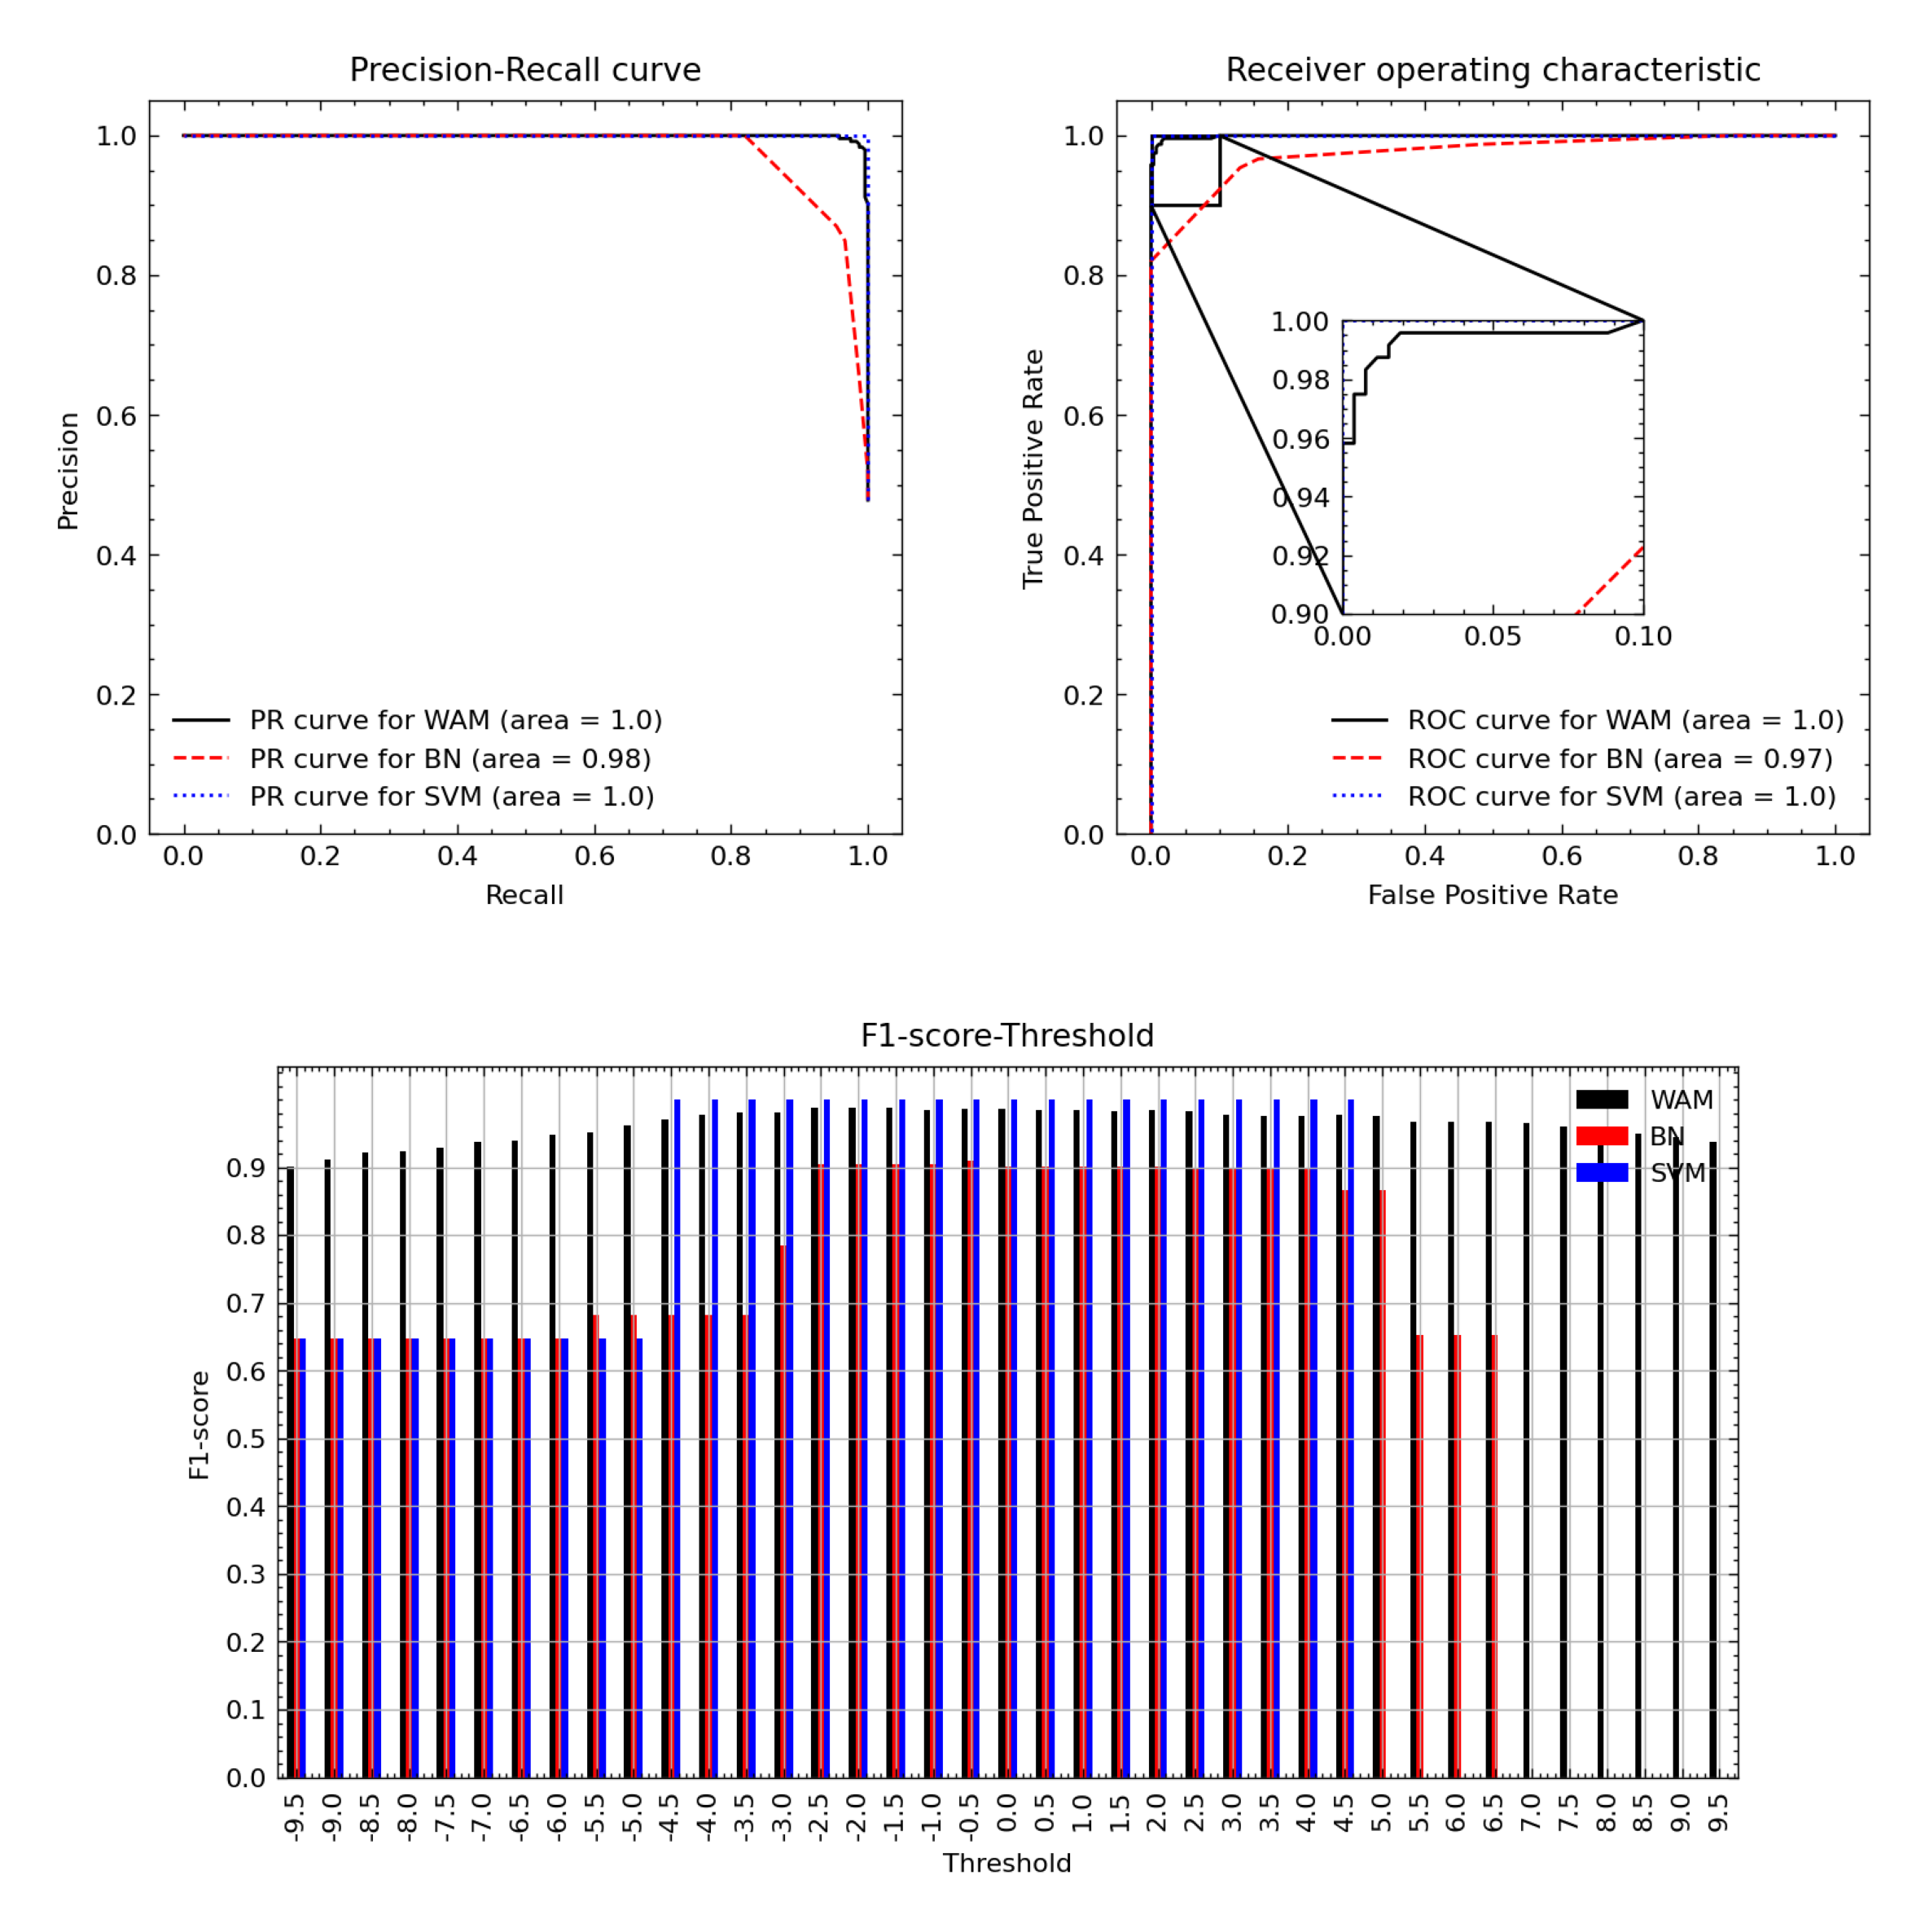

In [23]:
evaltr_2 = Evaluator(labels=testing_set2['IsDonor'], 
                  wam_scores=scores_wam_2, 
                  bn_scores=scores_bn_2, 
                  svm_scores=scores_svm_2)
fig, ax = plt.subplots(1,1, figsize=(8,4), dpi=200)
evaltr_2.F1_t_Curves(fig, ax, T_range=np.arange(-10,10,0.5), xlim=[-10,10])
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
evaltr_2.ROC_Curves(fig, ax, T_range=trange, xlim=[-0.05, 1.05])
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
evaltr_2.PR_Curves(fig, ax, T_range=trange, xlim=[-0.05, 1.05])

figs = [pli.imread(i) for i in ['../Figures/F1_t.png', '../Figures/ROC.png', 
                                '../Figures/PRC.png']]

def no_box(ax):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    for key, spine in ax.spines.items():
        spine.set_visible(False)

plt.figure(figsize=(12,12), dpi=200)
plt.subplots_adjust(left=0.0,bottom=0.0,top=1,right=1)
ax1 = plt.subplot(2,2,1)
no_box(ax1); plt.imshow(figs[2])
ax2 = plt.subplot(2,2,2)
no_box(ax2); plt.imshow(figs[1])
ax3 = plt.subplot(2,1,2)
no_box(ax3); plt.imshow(figs[0])

plt.tight_layout() 

In [22]:
import pickle

d = {'m1': model_1, 'm2': model_2, 'e1': evaltr_1, 'e2':evaltr_2}
with open('../models/models_eval.pkl', 'wb') as f:
    pickle.dump(d, f)

## Conclusion

### Model selection and dealing with unbalanced data

### Bayesian network suffers from learning algorithm
1. cons:
    1. Running time too long.
    2. Many shortages when hundreds of nodes involved.
    3. Too much parameters to be learn when there are too much edges in DAG.
2. pros: 
    1. white box, easy to visualize.
    2. Bayes inferance for Causual relationship inferance
    3. Intermediate features involved for manual knowledge discovering.

### SVM: everything for classification
1. pros:
    1. Very very high accuracy.
    2. Short running time.
2. cons:
    1. Hard to visualize.
    2. No intermediate feature involved.
    3. No causual relatinoship. Black box.
    4. Biclassification
    
### WAM: basic but 

### ROC or PRC

In [ ]:
bayesian network performence

other methods

limitations

future research

## References


[1] Tsamardinos, I., Brown, L.E. & Aliferis, C.F. The max-min hill-climbing Bayesian network structure learning algorithm. Mach Learn 65, 31–78 (2006). https://doi.org/10.1007/s10994-006-6889-7
